# Transformer *HSTU* tutorial
This guide tells about *Hierarchical Sequential Transduction Unit* *(HSTU)* - self-attention mechanism proposed in paper [Actions Speak Louder than Words: Trillion-Parameter Sequential Transducers
for Generative Recommendations](https://arxiv.org/abs/2402.17152). Also we show RecTools implementation metrics results on datasets movielens-1m and movielens-20m preprocessed by authors of the paper and preprocessed by RecTools framework

### Table of Contents

*  Review of HSTU
*  Reproduce RecTools implementation in fully original paper setup
*  Variation relative positional and time attentions
*  Time context implementation details



### Review of *HSTU*

*HSTU* - is self-attention mechanism challenging recommendation systems problems. We make short overview.


<div style="text-align:center">
    <img src="src/hstu_overview.png" alt="Описание" width="30%">
</div>

In the simplest case, a unified sequence refers to a sequence of user interactions — even without interleaving actions. Using this setup, the paper reports its main experimental results (metrics). The training objective follows the standard shifted-language-modeling approach. Additionally, the paper proposes a modified training procedure that generates multiple training examples at the end of each sequence. This variant is designed for large industrial-scale applications, where it helps reduce the time complexity of streaming and fine-tuning setups.

\begin{equation}
U(X), V(X), Q(X), K(X) = \text{Split}(\phi_1(f_1(X))) \tag{1}
\end{equation}

\begin{equation}
A(X)V(X) = \frac{\phi_2 \left( Q(X)K(X)^T + \text{rab}^{p,t} \right) V(X)}{N} \tag{2}
\end{equation}

\begin{equation}
Y(X) = f_2 \left( \text{Norm}(A(X)V(X)) \odot U(X) \right) \tag{3}
\end{equation}

where $ f_{i} $ is a linear mapping, $\phi$ is the SiLU function, and $\text{rab}^{p,t} $ is the sum of two attention matrices: relative positional attention  and relative time attention. The first important change is the use of elementwise SiLU instead of SoftMax. This approach allows for faster learning in a setting where the set of items is constantly changing. Moreover, the denominator of the softmax normalizes attention, capturing all the previous context of user interactions, and this is not always justified. SiLU changes the absolute value of token-to-token attention. The second change is the weighting of the classic self-attention output by the $U(X)$ matrix, which solves the DLRM problem of feature interaction.


$\text{rab}^{t}$ - relative time attention, the picture shows first stage matrice formation

<div style="text-align:center">
    <img src="src/time_attention.jpg" alt="Описание" width="40%">
</div>


\begin{equation}
    a_{i,j} = t_{i+1} - t_j
\end{equation}
\begin{equation}
\text{bucket}(a_{i,j}) =
\left\lfloor
\frac{\log(|a_{i,j}| \vee 1)}{0.301}
\right\rfloor
\end{equation}

To predict the next item, we use the time of its appearance. This is a simulation of inference with time aware setup. In the current formulation, this is a candidate generation model, and based on real interest, in addition to the user's history, we would also provide the start time of his session. In this case, the last token, or the last row in the attention matrix, will be conditioned on the start time of the user's session. In this way, the consistency of the model is maintained between training and testing (real-world inference).That is, all possible differences $a_{i,j}$ are quantized into buckets with logarithmic asymptotics. If the banquet values are greater than the specified $b_{max}$, then it is truncated to the maximum. Each bucket value corresponds to the learning parameter $w_{i}$, which is substituted instead of $a_{i,j}$. Thus, we form the matrix $\text{rab}^{t}$. Moreover, we note that the time quantization function and the maximum number of buckets are hyperparameters. We can vary them depending on the nature of the content.

Quantification of the timestamp difference actually breaks down the user's previous history into time microsessions relative to the query generation moment.



### RecTools implementation

Details of the implementation.
1) Has been written from jagged tensors to usual torch tensors
2) Has been droped original paper init distributions over all parameters where it possible, and replaced by xavier distribution
3) Left padding isntead of right for consistency to RecTools
4) No Q,K caching option

In [3]:
import os
import warnings

import torch
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import ast
from rectools.dataset import Dataset
from rectools.models import HSTUModel
from rectools import Columns
from scipy import sparse
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from rectools.model_selection.splitter import Splitter
from rectools.model_selection import LastNSplitter
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
from rectools.metrics import (
    CoveredUsers,
    Serendipity,
    NDCG,
    AvgRecPopularity,
    CatalogCoverage,
    Recall,
    SufficientReco,
)
from rectools.models import  SASRecModel
from rectools.model_selection import  cross_validate
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools.models.nn.transformers.utils import  leave_one_out_mask
import json
from utils import  RecallCallback, BestModelLoadCallback, get_results

In [4]:
RANDOM_STATE=42
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 42


42

### RecTools recalculated

#### Results on MovieLens-1M (ml-1m)
| Method              | HR@10  | NDCG@10 | HR@50  | NDCG@50 | HR@200 | NDCG@200 |
|---------------------|--------|---------|--------|---------|--------|----------|
| HSTU paper          | 0.3097 | 0.1720  | 0.5754 | 0.2307  | 0.7716 | 0.2606   |
| HSTU RecTools       | 0.3077 | 0.1724  | 0.5818 | 0.2330  | 0.7829 | 0.2636   |
| HSTU-large paper    | 0.3294 | 0.1893  | 0.5935 | 0.2481  | 0.7839 | 0.2771   |
| HSTU-large RecTools | 0.3291 | 0.1871  | 0.6007 | 0.2471  | 0.7957 | 0.2770   |



#### Results on MovieLens-20M (ml-20m)
| Method              | HR@10  | NDCG@10 | HR@50  | NDCG@50 | HR@200 | NDCG@200 |
|---------------------|--------|---------|--------|---------|--------|----------|
| HSTU paper          | 0.3273 | 0.1895  | 0.5889 | 0.2473  | 0.7952 | 0.2787   |
| HSTU RecTools       | 0.3309 | 0.1914  | 0.5946 | 0.2450  | 0.8009 | 0.2812   |

#### LOO validation, LOO test setup

In [5]:
loo_splitter = LastNSplitter(1,1,filter_cold_users = False, filter_cold_items = False)

In [18]:
def get_movielens_df(dataset_name: str = "ml-1m") -> pd.DataFrame:
    if dataset_name == "ml-1m":
        
        ratings = pd.read_csv(
            "ml-1m/ratings.dat",
            sep="::",
            names=["userId", "movieId", "rating", "timestamp"],
            engine="python",
        )
    elif dataset_name == "ml-20m":
        ratings = pd.read_csv("ml-20m/ratings.csv")
    ratings = ratings[ratings["rating"] >= 0]
    ratings.rename(
        columns={
            "userId": Columns.User,
            "movieId": Columns.Item,
            "timestamp": Columns.Datetime,
        },
        inplace=True,
    )
    ratings[Columns.Datetime] = pd.to_datetime(ratings[Columns.Datetime], unit="s")
    ratings[Columns.Weight] = 1
    return ratings

In [19]:
# Callback for calculating RecSys metrics
RECALL_K = 10
PATIENCE = 5
DIVERGENCE_TRESHOLD = 0.01
recall_callback = RecallCallback(k=RECALL_K, progress_bar=True)
# Checkpoints based on best recall
max_recall_ckpt = ModelCheckpoint(
    monitor=f"recall@{RECALL_K}",   # or just pass "val_loss" here,
    mode="max",
    filename="best_recall",
)
early_stopping_recall = EarlyStopping(
    monitor=f"recall@{RECALL_K}",
    mode="max",
    patience=PATIENCE,
    divergence_threshold=DIVERGENCE_TRESHOLD,
)
best_model_load = BestModelLoadCallback("best_recall")
callbacks = [recall_callback, max_recall_ckpt, best_model_load]

In [20]:
# Function to get custom trainer
def get_trainer() -> Trainer:
    return Trainer(
        accelerator="gpu",
        devices=1,
        min_epochs=100,
        max_epochs=100,
        deterministic=True,
        enable_model_summary=False,
        enable_progress_bar=True,
        callbacks=callbacks,
        logger = CSVLogger("test_logs"),  # We use CSV logging for this guide but there are many other options
    )

In [21]:
metrics_add = {}
metrics_recall ={}
metrics_ndcg = {}
k_base =  10
K = [10, 50,100,200]
K_RECS= max(K)
for k in K:
    metrics_recall.update({
            f"recall@{k}": Recall(k=k),
        })
    metrics_ndcg.update({
            f"ndcg@{k}": NDCG(k=k, divide_by_achievable=True),
        })
metrics_add = {
    f"arp@{k_base}": AvgRecPopularity(k=k_base, normalize=True),
    f"coverage@{k_base}": CatalogCoverage(k=k_base, normalize=True),
    f"covered_users@{k_base}": CoveredUsers(k=k_base),
    f"sufficient_reco@{k_base}": SufficientReco(k=k_base),
    f"serendipity@{k_base}": Serendipity(k=k_base),
}
metrics  = metrics_recall | metrics_ndcg | metrics_add
metrics_to_show = ['recall@10', 'ndcg@10', 'recall@50', 'ndcg@50', 'recall@200', 'ndcg@200', 'coverage@10',
                       'serendipity@10']

In [10]:
def evaluate(models: dict, splitter:Splitter,dataset: Dataset, path_to_save_res:str) -> None:
    cv_results = cross_validate(
        dataset=dataset,
        splitter=splitter,
        models=models,
        metrics=metrics,
        k=K_RECS,
        filter_viewed=True,
    )
    cv_results["models_log_dir"] = {}
    for model_name, model in models.items():
        cv_results["models_log_dir"].update({model_name:model.fit_trainer.log_dir})
    with open(path_to_save_res, 'w', encoding='utf-8') as f:
        json.dump(cv_results, f, ensure_ascii=False, indent=4)

#### MovieLens-1M (ml-1m)

In [11]:
%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ml-1m.zip
!unzip -o ml-1m.zip
!rm ml-1m.zip

Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
CPU times: user 7.41 ms, sys: 49.8 ms, total: 57.2 ms
Wall time: 2.35 s


In [12]:
config = {
    "session_max_len": 200,
    "lightning_module_kwargs": {"logits_t": 0.05}, # logits scale factor
    "item_net_block_types": (IdEmbeddingsItemNet,),
    "get_val_mask_func": leave_one_out_mask,
    "get_trainer_func": get_trainer,
    "verbose": 1,
    "loss": 'sampled_softmax',
    "n_negatives": 128,
    "use_pos_emb": True,
    "dropout_rate": 0.2,
    "n_factors": 50, # embedding dim
    "n_heads": 1,
    "n_blocks": 2,
    "lr": 0.001,
    "batch_size": 128,
}
config_large = config.copy()
config_large["n_blocks"] = 8
config_large["n_heads"] = 2

In [13]:
dataset_name = "ml-1m"
pivot_name = f"pivot_results_{dataset_name}.json"
ml_df = get_movielens_df(dataset_name)
dataset = Dataset.construct(ml_df)

In [37]:
hstu  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=True,
    **config
)
hstu_large  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=True,
    **config_large
)
models = {
    "hstu": hstu,
    "hstu_large": hstu_large,
}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
evaluate(models,loo_splitter,dataset,pivot_name)

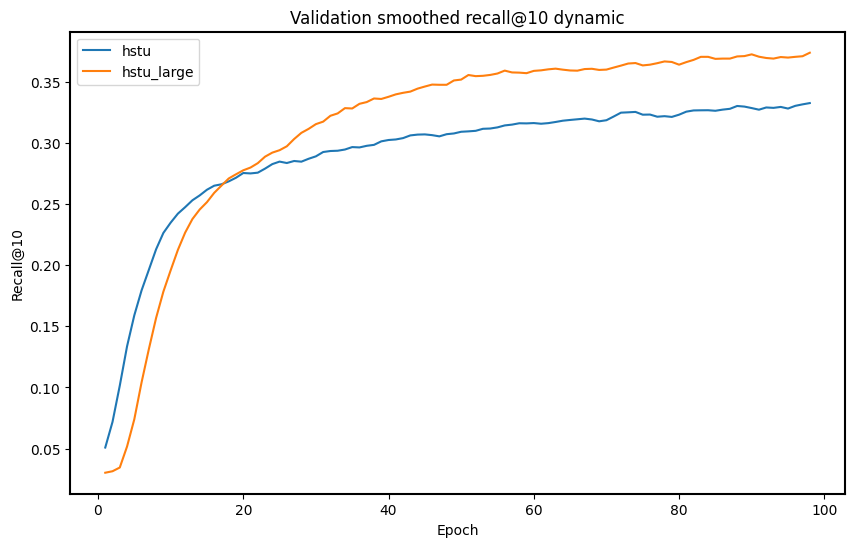

,recall@10,ndcg@10,recall@50,ndcg@50,recall@200,ndcg@200,coverage@10,serendipity@10
model,,,,,,,,
hstu,0.322682,0.187915,0.589404,0.247056,0.785762,0.276861,0.650378,0.002877
hstu_large,0.364238,0.216433,0.619371,0.273545,0.803146,0.301466,0.684665,0.003299


In [14]:
pivot_table = get_results(pivot_name,metrics_to_show, show_loss=False)
pivot_table

#### MovieLens-20M (ml-20m)

In [1]:
%%time
!wget -q https://files.grouplens.org/datasets/movielens/ml-20m.zip -O ml-20m.zip
!unzip -o ml-20m.zip
!rm ml-20m.zip

Archive:  ml-20m.zip
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         
CPU times: user 77.8 ms, sys: 32.8 ms, total: 111 ms
Wall time: 14.6 s


In [14]:
config_ml_20m  = config.copy()
config_ml_20m["n_factors"] = 256
config_ml_20m["n_heads"] = 4
config_ml_20m["n_blocks"] = 4

In [15]:
hstu  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=True,
    **config_ml_20m
)
models = {
    "hstu": hstu,
}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)
dataset_name = "ml-20m"
pivot_name = f"pivot_results_{dataset_name}.json"

Seed set to 42


In [23]:
ml_df = get_movielens_df(dataset_name)
dataset = Dataset.construct(ml_df)

In [ ]:
evaluate(models,loo_splitter,dataset,pivot_name)

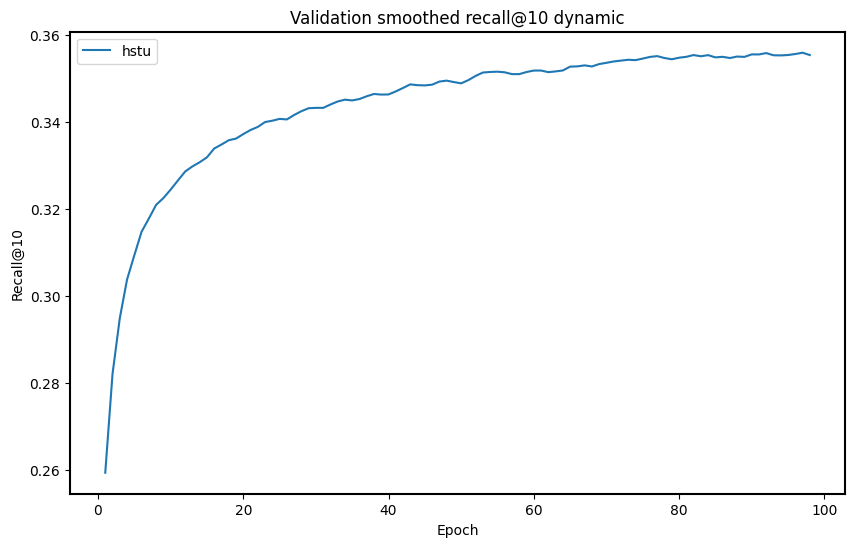

,recall@10,ndcg@10,recall@50,ndcg@50,recall@200,ndcg@200,coverage@10,serendipity@10
model,,,,,,,,
hstu,0.330856,0.191414,0.594629,0.249778,0.800861,0.281208,0.31898,0.000785


In [22]:
pivot_table = get_results(pivot_name,metrics_to_show, show_loss=False)
pivot_table

#TODO launch
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

In the original article, the dataset was preprocessed incorrectly. The user interactions were sorted by timestamp without a stable sorting option, which means that interactions with the same timestamp could be reordered.
See the reference code:
https://github.com/meta-recsys/generative-recommenders/blob/88512dbd71b053226bc4ef8ec1630e3db53e55e5/generative_recommenders/research/data/preprocessor.py#L267

Therefore, we also report results on a dataset preprocessed using RecTools, where interactions are sorted stably by timestamp. Additionally, we provide an ablation study to highlight the impact of this preprocessing difference.

### Ablation study 



In [10]:
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)
dataset_name = "ml-1m"
pivot_name = f"pivot_results_ablation_{dataset_name}.json"
ml_df = get_movielens_df("ml-1m")
dataset = Dataset.construct(ml_df)

Seed set to 42


#### rab - relativate attention bias

In [11]:
hstu  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=True,
    **config
)
hstu_rab_p  = HSTUModel(
    relative_time_attention=False,
    relative_pos_attention=True,
    **config
)
hstu_rab_t  = HSTUModel(
    relative_time_attention=True,
    relative_pos_attention=False,
    **config
)
hstu_no_rab  = HSTUModel(
    relative_time_attention=False,
    relative_pos_attention=False,
    **config
)
sasrec = SASRecModel(
    **config
)
models = {
    "hstu_rab_t": hstu_rab_t,
    "hstu_rab_p": hstu_rab_p,
    "hstu": hstu,
    "hstu_no_rab": hstu_no_rab,
    "sasrec": sasrec,
}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
evaluate(models,loo_splitter,dataset,pivot_name)

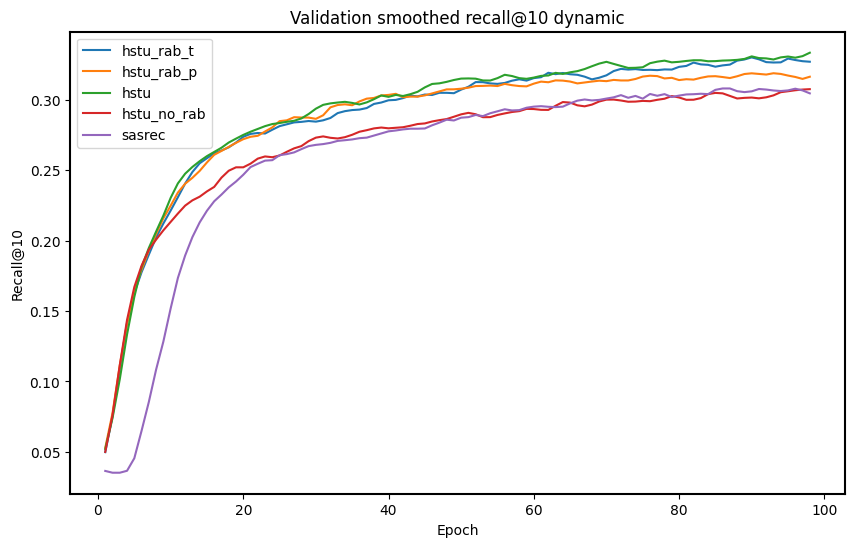

,recall@10,ndcg@10,recall@50,ndcg@50,recall@200,ndcg@200,coverage@10,serendipity@10
model,,,,,,,,
hstu_rab_t,0.318709,0.184810,0.590728,0.245153,0.787583,0.275103,0.639309,0.002821
hstu_rab_p,0.308609,0.174476,0.577483,0.233951,0.770364,0.263386,0.647948,0.002748
hstu,0.325828,0.189466,0.589901,0.248061,0.784603,0.277562,0.643359,0.002860
hstu_no_rab,0.298013,0.168559,0.559934,0.226351,0.766060,0.257793,0.618251,0.002535
sasrec,0.287748,0.162196,0.551821,0.220394,0.763245,0.252509,0.660367,0.002623


In [13]:
pivot_table = get_results(pivot_name,metrics_to_show, show_loss=False)
pivot_table

### Context-aware recommendation details

If you use relative_time_attention, it's required to pass the query generation moment for users to make correct recommendations

In [16]:
from rectools.dataset.context import  get_context
users = [1,2,3] # users we are recommending for
query_time = max(ml_df[Columns.Datetime]) # for example
context_df = pd.DataFrame(
    {
        Columns.User: [1, 2, 3],
        Columns.Datetime: [query_time]*3,
    }
)
context = get_context(context_df) # context preprocessing

In [18]:
hstu.recommend(
    users =users,
    dataset= dataset,
    k =3,
    filter_viewed=True,
    context=context)

,user_id,item_id,score,rank
0,1,318,0.230197,1
1,1,2858,0.219218,2
2,1,593,0.213117,3
3,2,260,0.249361,1
4,2,1,0.221973,2
5,2,1270,0.213058,3
6,3,2804,0.329420,1
7,3,2918,0.328336,2
8,3,1,0.324877,3


To use the recommend method, you must provide the appropriate context based on the model's requirements. See the details below

In [19]:
hstu.require_recommend_context, hstu_rab_p.require_recommend_context

(True, False)

In [21]:
hstu.recommend(
    users=users,
    dataset=dataset,
    k=3,
    filter_viewed=True,
    context=None)

ValueError: This model requires `context` to be provided for recommendations generation (model.require_recommend_context is True).Check docs and examples for details.